<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Исходные данные

base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

validation_answer.csv - правильные ответы к предыдущему файлу.

Задача: 

разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;

оценить качество алгоритма по метрике accuracy@5

*деплой: разработать REST API сервис, который по предложенным данным будем предлагать несколько похожих товаров.


Data load and exploratory analysis

In [56]:
import pandas as pd
import numpy as np
import faiss
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler


Загрузить данные и проверить на:
- явные дубликаты
- выбросы
- пропуски

In [57]:
try:
    df_base = pd.read_csv("/Users/coldpiold/Desktop/practicum/мастерская_2/base.csv", index_col=0)
except:
    df_train = pd.read_csv('base.csv', index_col=0)


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


<class 'pandas.core.frame.DataFrame'>
Index: 616842 entries, 0-base to 698669-base
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       616842 non-null  float64
 1   1       616842 non-null  float64
 2   2       616842 non-null  float64
 3   3       616842 non-null  float64
 4   4       616842 non-null  float64
 5   5       616842 non-null  float64
 6   6       616842 non-null  float64
 7   7       616842 non-null  float64
 8   8       616842 non-null  float64
 9   9       616842 non-null  float64
 10  10      616842 non-null  float64
 11  11      616842 non-null  float64
 12  12      616842 non-null  float64
 13  13      616842 non-null  float64
 14  14      616842 non-null  float64
 15  15      616842 non-null  float64
 16  16      616842 non-null  float64
 17  17      616842 non-null  float64
 18  18      616842 non-null  float64
 19  19      616842 non-null  float64
 20  20      616842 non-null  float64
 21  21   

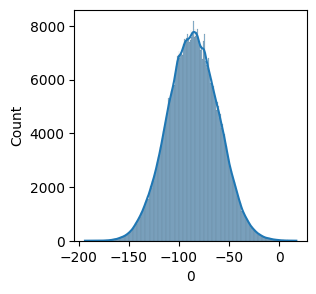

1


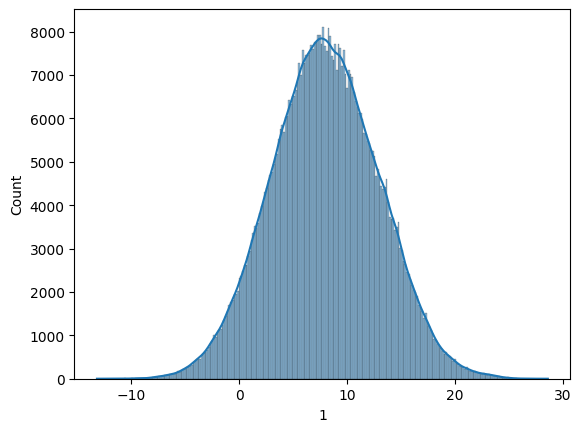

2


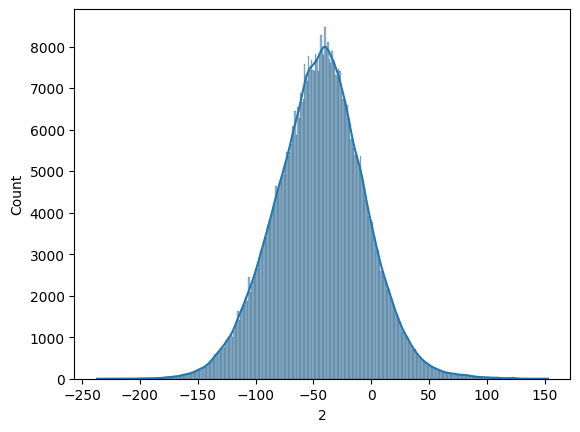

3


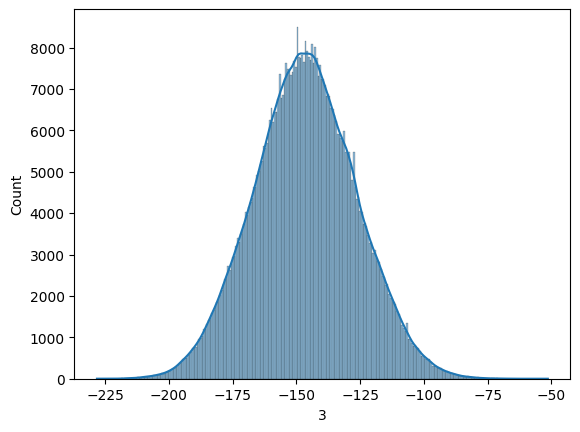

4


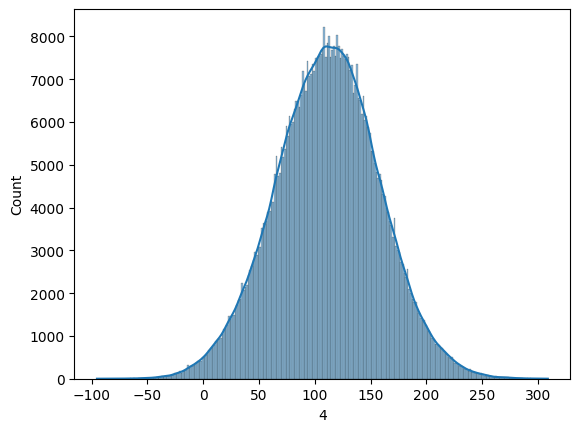

5


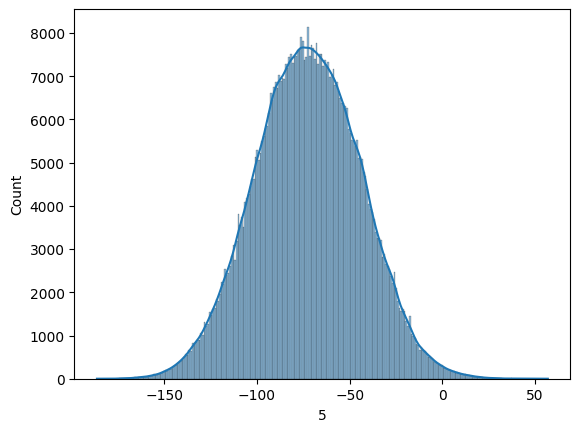

6


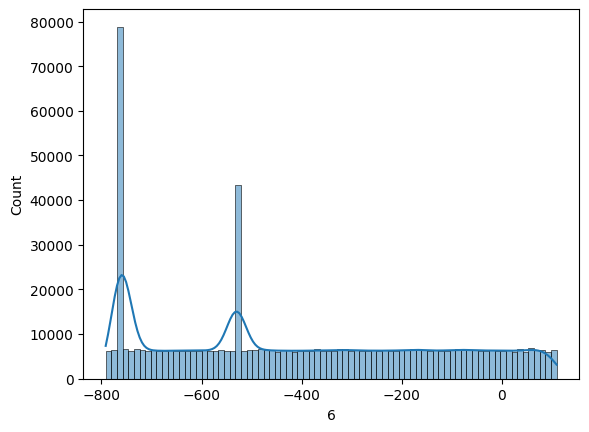

7


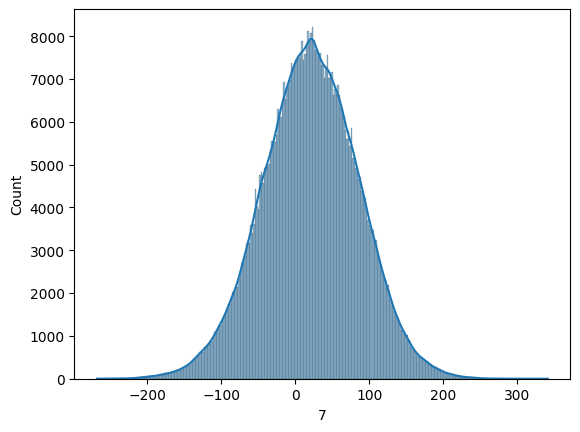

8


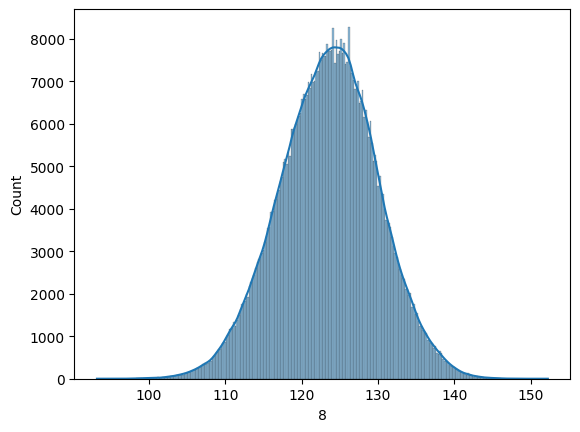

9


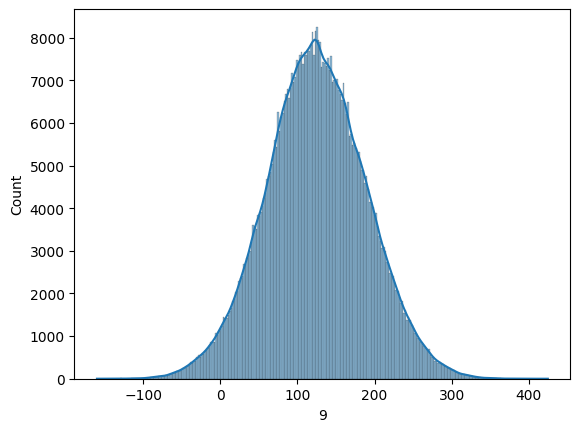

10


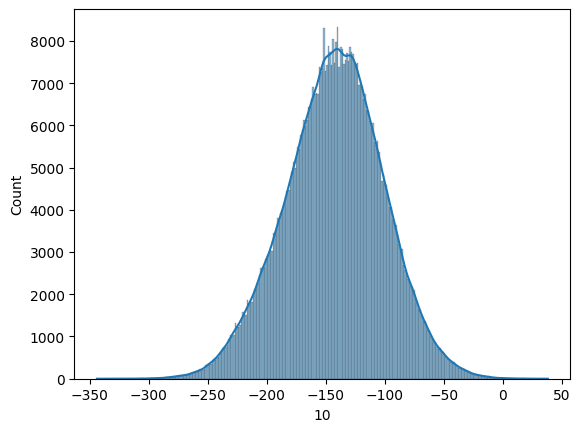

In [58]:
display(df_base.head())

print(df_base.info())

print(df_base.shape)
    
dupl = df_base.duplicated().sum()
print(dupl)
if dupl > 0:
    df_base.drop_duplicates(inplace=True)

fig, axs = plt.subplots(figsize=(3, 3))

for x in ['0', '1', '2', '3', '4', '5','6', '7', '8', '9', '10']:
    print(x)
    sns.histplot(data=df_base, x=x, kde=True)
    plt.show()
    
    

In [59]:
df_base.tail(5)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
698661-base,-41.298500,8.639521,-30.534400,-139.591370,145.299710,-39.070595,-557.727319,-82.672905,119.378960,175.03139,...,-72.038345,9.916176,-222.53671,76.743814,63.35016,19.166721,3.053227,109.67078,-1074.464888,-48.886787
698663-base,-92.599810,10.615265,-30.193970,-187.519930,133.210270,-99.236780,-108.759894,24.615147,137.360000,178.31561,...,-109.686890,32.537663,-116.80877,161.176270,67.18825,5.744109,-11.765205,85.21034,-1074.464888,-86.332120
698664-base,-88.844246,16.568968,-61.401947,-136.888980,144.858980,-72.023480,-548.014779,98.497410,125.143240,226.12663,...,-92.420810,14.102180,-137.26120,-119.559771,68.28819,-34.623623,147.666370,102.18305,-1074.464888,-36.625480
698668-base,-65.555466,-0.102067,-57.422490,-124.259520,176.158200,-88.087020,-709.580082,-120.112144,129.027330,42.38199,...,-101.475920,25.261454,-208.96701,-79.401142,66.09446,70.073640,100.074640,101.76736,12.380567,-68.937450
698669-base,-50.798920,7.930684,-125.483284,-127.553406,127.368935,-92.526260,-257.740204,126.003426,125.798256,214.29120,...,-144.738620,66.373460,-128.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
df_base.fillna(0,inplace=True)

In [61]:
df_base.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71'],
      dtype='object')

In [62]:
df_base_non_normal = ['70','65','63','59','44','33','25','21','6']
df_base_normal = ['0', '1', '2', '3', '4', '5', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '22', '23', '24', '26', '27', '28', '29', '30', '31', '32' 
        , '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '60',
       '61', '62', '64', '66', '67', '68', '69', '71']

In [63]:
try:
    df_train = pd.read_csv("/Users/coldpiold/Desktop/practicum/мастерская_2/train.csv", index_col=0)
except:
    df_train = pd.read_csv("train.csv", index_col=0)


In [64]:
display(df_train.head())    

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [65]:
st_scaler = StandardScaler()

mm_scaler = MinMaxScaler()

st_scaler.fit(df_base[df_base_normal])
mm_scaler.fit(df_base[df_base_non_normal])

df_base_st_scaled = pd.DataFrame(data=st_scaler.transform(df_base[df_base_normal]),
                                index=df_base.index,
                                columns=df_base_normal)

df_base_mm_scaled = pd.DataFrame(data=mm_scaler.transform(df_base[df_base_non_normal]),
                                index=df_base.index,
                                columns=df_base_non_normal)

df_base_scaled = pd.concat([df_base_st_scaled,df_base_mm_scaled],axis=1)

display(df_base_scaled)

,0,1,2,3,4,5,7,8,9,10,...,71,70,65,63,59,44,33,25,21,6
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-1.158299,0.644797,-0.516075,1.378901,2.248239,-1.137183,0.366572,-0.408826,0.879850,0.446448,...,-0.309327,0.848554,0.242799,0.517225,0.940281,0.119723,0.559819,0.964712,0.964664,0.357782
1-base,2.040637,1.084003,-0.654413,-0.998908,-1.148769,-0.480571,-0.868394,-0.595559,1.093340,0.031649,...,-0.277930,0.868506,0.184269,0.526847,0.587977,0.662153,0.816791,0.964712,0.206286,0.783921
2-base,1.259133,-0.316996,0.392696,0.653724,0.845243,-0.951396,0.645009,0.845121,0.615504,0.043242,...,0.371241,0.159996,0.831420,0.547401,0.207798,0.347655,0.291806,0.964712,0.964664,0.936658
3-base,-0.063256,-0.788769,-1.119304,-1.923740,-0.748985,0.476587,-0.837109,-0.234598,0.179559,0.821511,...,-0.599922,0.159996,0.349882,0.328246,0.192828,0.973035,0.568510,0.964712,0.944912,0.453096
4-base,0.523771,-0.288249,2.273412,0.294742,-2.258144,-1.397573,0.379455,-0.213491,-0.193919,0.776478,...,1.161059,0.159996,0.710667,0.591887,0.207297,0.640315,0.427236,0.412739,0.792687,0.436974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698661-base,1.773020,0.138389,0.358523,0.345472,0.725534,1.179617,-1.594615,-0.648562,0.780446,0.579954,...,-0.022136,0.159996,0.683818,0.396352,0.084631,0.748713,0.568510,0.964712,0.948110,0.259395
698663-base,-0.265059,0.536470,0.367308,-2.046107,0.466923,-0.944387,0.061898,2.157185,0.831311,-0.994613,...,-0.922534,0.159996,0.930200,0.491016,0.456454,0.109936,0.568510,0.964712,0.325775,0.757638
698664-base,-0.115860,1.736047,-0.438019,0.480318,0.716106,0.016305,1.202631,0.250891,1.571791,-0.164826,...,0.272695,0.159996,0.110987,0.413869,0.957493,0.035317,0.266531,0.964712,0.964664,0.270174


In [66]:
df_train_st_scaled = pd.DataFrame(data=st_scaler.transform(df_train[df_base_normal]),
                                index=df_train.index,
                                columns=df_base_normal)

df_train_mm_scaled = pd.DataFrame(data=mm_scaler.transform(df_train[df_base_non_normal]),
                                index=df_train.index,
                                columns=df_base_non_normal)

df_train_scaled = pd.concat([df_train_st_scaled,df_train_mm_scaled],axis=1)

display(df_train_scaled)

,0,1,2,3,4,5,7,8,9,10,...,71,70,65,63,59,44,33,25,21,6
Id,,,,,,,,,,,,,,,,,,,,,
0-query,1.273078,2.018622,0.059629,-1.867307,1.628635,-0.517517,0.273308,-2.254736,-1.459346,1.311965,...,0.529188,0.631618,0.162327,0.648233,0.973628,0.662153,0.816791,0.964712,0.536117,0.492850
1-query,-0.073436,-0.230983,0.319295,-1.534168,0.201520,-0.399807,-1.529153,0.215418,0.243019,-0.841628,...,-0.079606,0.188186,0.455091,0.374395,0.305840,0.942648,0.906750,0.964712,0.152279,0.773383
2-query,1.428142,-0.828340,-1.849992,-1.690929,1.684487,0.764214,-0.788262,0.348872,1.346929,1.353729,...,0.611217,0.159996,0.699577,0.681428,0.709703,0.699068,0.029573,0.964712,0.964664,0.908236
3-query,1.514311,0.228468,-1.831492,1.272593,-0.357878,-1.298068,0.904473,0.072985,1.827710,-0.093749,...,0.674803,0.159996,0.734147,0.541138,0.413420,0.686542,0.029573,0.964712,0.964664,0.018109
4-query,0.250116,1.307675,-0.373544,-0.026832,-1.160610,1.985606,0.391841,0.375418,-0.329070,0.853203,...,0.644829,0.159996,0.116629,0.543288,0.654764,0.211603,0.291806,0.964712,0.964664,0.521751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995-query,0.705061,0.746467,-0.483895,-2.106315,0.422061,0.259825,1.163928,-0.744959,-2.017664,0.508848,...,0.308697,0.159996,0.500845,0.516274,0.251305,0.518550,0.291806,0.964712,0.964664,0.307614
99996-query,0.770200,-1.158849,-0.667432,0.017313,-0.718019,0.881134,-0.706984,1.242767,0.907901,1.632893,...,-1.459507,0.109788,0.213445,0.494311,0.215317,0.711650,0.904809,0.964712,0.964664,0.746280
99997-query,1.270476,-0.649946,0.390920,-0.033333,3.266649,-1.011421,0.732643,-0.850578,1.050208,-1.572380,...,1.050690,0.417437,0.526905,0.295655,0.068587,0.628332,0.594336,0.964712,0.423998,0.403866


In [67]:
try:
    df_valid = pd.read_csv("/Users/coldpiold/Desktop/practicum/мастерская_2/validation.csv", index_col=0)
except:
    df_valid = pd.read_csv("validation.csv", index_col=0)

df_valid.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


try:
    df_valid_answer = pd.read_csv("/Users/coldpiold/Desktop/practicum/мастерская_2/validation_answer", index_col=0)
except:
    df_valid_answer = pd.read_csv("validation_answer", index_col=0)

df_valid_answer.head()

Baseline

Create index

In [68]:
dims = df_base_scaled.shape[1]
n_cells = 1
# how many cells
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [69]:
idx_l2.train(np.ascontiguousarray(df_base_scaled.values).astype('float32'))

In [70]:
i_1 = []
for i in range(0,9):
    i_1.append(i*34269)
    
print(i_1)

[0, 34269, 68538, 102807, 137076, 171345, 205614, 239883, 274152]


In [71]:
i_2 = []
for i in range(1,10):
    a = i*34269 - 1
    i_2.append(a)
    
i_2[8] = 616842
print(i_2)

[34268, 68537, 102806, 137075, 171344, 205613, 239882, 274151, 616842]


In [72]:
for i in (0,8):
    idx_l2.add(np.ascontiguousarray(df_base_scaled.values[i_1[i]:i_2[i], :]).astype('float32'))

In [73]:
base_index = {k: v for k, v in enumerate(df_base_scaled.index.to_list())}

#del df_base

Train

In [74]:
targets = df_train["Target"]
#df_train.drop("Target", axis=1, inplace=True)

In [ ]:
r, idx = idx_l2.search(np.ascontiguousarray(df_train_scaled.values).astype('float32'), 5)

In [ ]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))